In [1]:
# change to the /srv/jupyter/$username directory where we have write permission
import os;
import pwd;
# change to a directory where we have write permission
#os.chdir(os.path.join("/srv/jupyter", pwd.getpwuid(os.getuid()).pw_name));
os.chdir("./")

# OCR Experiment

In this notebook we will be implementing a simple OCR experiment using TensorFlow.

## Let's start with some data:

Consider the following file, <i>digits.txt</i> (if you run the cell below (a copy of the file will be created for you).

In [2]:
%%file digits.txt
00000   11111   22222   33333   44444   55555   66666   77777   88888   99999
 XXX      X      XXX     XXX       X    XXXXX    XXX    XXXXX    XXX     XXX 
X   X    XX         X       X     XX    X       X          X    X   X   X   X
X   X     X        X     XXX     X X    XXXX    XXXX      X      XXX     XXXX
X   X     X       X         X   XXXXX       X   X   X    X      X   X       X
 XXX     XXX    XXXXX    XXX       X    XXXX     XXX    X        XXX     XXX 

Overwriting digits.txt


Now let's store these digit images in a python dictionary.

In [3]:
fp = open( "digits.txt");
lines = fp.readlines();
fp.close();

image = { i:'' for i in range(0,10) };
print(image)
for line in lines[1:]:  # start with the second line
    for digit in range(0,10):
        image[digit] += line[0:5]+'\n';
        line = line[8:];

{0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''}


## Printing the images.

In [4]:
for digit in range(0,10):
    print (image[digit]);
    print;

 XXX 
X   X
X   X
X   X
 XXX 

  X  
 XX  
  X  
  X  
 XXX 

 XXX 
    X
   X 
  X  
XXXXX

 XXX 
    X
 XXX 
    X
 XXX 

   X 
  XX 
 X X 
XXXXX
   X 

XXXXX
X    
XXXX 
    X
XXXX 

 XXX 
X    
XXXX 
X   X
 XXX 

XXXXX
   X 
  X  
 X   
X    

 XXX 
X   X
 XXX 
X   X
 XXX 

 XXX 
X   X
 XXXX
    X
 XXX 



## Input data
In order to present these images to a network, we will need to encode them numerically.  We can do this by representing the dark ("X") pixels with ones and the light (" ") pixels with zeros.  Here's a handy function for that.

In [5]:
def image2bits( image ):
    "convert image to bits by coding X as 1 and blank as 0; ignore newlines"
    return [ int(c=='X') for c in image if c!='\n' ];

Now we can use this to transfor any image to an <i>input vector</i>.

In [6]:
print (image2bits( image[0] ));

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]


In [7]:
print (image2bits( image[1] ));

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


In [8]:
print (image2bits( image[9] ));

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


It will also be useful to reverse the operation so that we can take an <i>input vector</i> and visualize it as an image.  Here's the function for that.

In [9]:
def bits2image( bits ):
    "convert bits to an image by coding 0 as blank and 1 as X; add newlines"
    lines = [ bits[j:j+5] for j in range(0, len(bits), 5) ];
    return "\n".join([ "".join([ " X"[i] for i in line]) for line in lines ]);

See, it works:

In [10]:
print (bits2image( image2bits( image[0] ) ));

 XXX 
X   X
X   X
X   X
 XXX 


In [11]:
print (bits2image( image2bits( image[1] ) ));

  X  
 XX  
  X  
  X  
 XXX 


## Output data
We also need output data.  In this case there will be 10 different classes of outputs.  A simple and popular output encoding is call the one-hot encoding.  In this scheme the n=10 different classes of outputs are represented by 10 different vectors, each vector being all zeros, except along a single dimension (where it is one).  Here's the function that genarates one-hot vectors:

In [12]:
def onehot(i,n):
    "return a list of n values with the ith value set to one"
    return [ int(i==j) for j in range(0,n)];

The digit 0 is encoded as:

In [13]:
print (onehot(0,10));

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


While digit 1 is represented as:

In [14]:
print (onehot(1,10));

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


And the last digit (9) is encoded as:

In [15]:
print (onehot(9,10));

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


There are other ways of encoding the output.  For example, we could have used a 4-digit binary representation:
<table>
  <tr>
    <td>0</td><td>0,0,0,0</td>
  </tr>
  <tr>
    <td>1</td><td>0,0,0,1</td>
  </tr>
  <tr>
    <td>2</td><td>0,0,1,0</td>
  </tr>
  <tr>
    <td>3</td><td>0,0,1,1</td>
  </tr>
  <tr>
    <td>4</td><td>0,1,0,0</td>
  </tr>
  <tr>
    <td>5</td><td>0,1,0,1</td>
  </tr>
  <tr>
    <td>6</td><td>0,1,1,0</td>
  </tr>
  <tr>
    <td>7</td><td>0,1,1,1</td>
  </tr>
  <tr>
    <td>8</td><td>1,0,0,0</td>
  </tr>
  <tr>
    <td>9</td><td>1,0,0,1</td>
  </tr>
</table>
But, note that in this representation the distances between output vectors is incosistent.  E.g. (0,1,1,0) and (1,0,0,1) are much further (by most norms) than (0,0,0,0) and (0,0,0,1).  This biases the system to treat some output patters as more similar than others.

## Input/Output pairs can be generated as follows:

In [16]:
print ( image2bits( image[0] ), onehot(0,10) );

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0] [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
import numpy as np;
DTYPE = 'float32'

def perfect_data():
    input_array = np.array([ image2bits( image[digit] ) for digit in range(0,10) ]);
    output_array = np.array([ onehot(digit,10) for digit in range(0,10) ]);
    return input_array.astype(DTYPE), output_array.astype(DTYPE);

In [18]:
print (perfect_data());

(array([[ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
     

## Adding Noise
This is very much a toy problem, but let's make it a little bit interesting, but adding noise.

We'll use a simple noise model that flips the pixels with a given probability.  Essentially we go though each dimension in the input vector and generate a random number between 0 and 1.  If it is below our noise probability we flip the pixel, otherwise we leave it alone.  Here's a function to apply this kind of noise to input vectors.

In [19]:
import random;

def addnoise( input, noise ):
    return [ i^(random.random()<noise) for i in input ];

We can test what happens when the noise probability is 0.0 - zero chance of flipping any of the bits:  nothing happens.

In [20]:
print (bits2image( addnoise( image2bits( image[0] ), 0.0 ) ));

 XXX 
X   X
X   X
X   X
 XXX 


With a probability of 1.0, the output is not random, but rather a negative image (inverse).

In [21]:
print (bits2image( addnoise( image2bits( image[0] ), 1.00 ) ));

X   X
 XXX 
 XXX 
 XXX 
X   X


With a 0.5 probability, the image becomes completely random because each bit has an equal probability of remainining what it was versus changing, so each bit has a 50/50 chance of being 1 or 0.

In [22]:
print (bits2image( addnoise( image2bits( image[0] ), 0.50 ) ));

 XXX 
 XXX 
XXXX 
   XX
   X 


Here's a loop that generates the image 0 with noise levels ranging from 0-100% at 5% intervals.

In [23]:
for noise in range( 0, 101, 5 ):
    print ("Noise: %3d%%\n" % noise);
    print (bits2image( addnoise( image2bits( image[0] ), noise/100.0) ));
    print ("\n\n\n");

Noise:   0%

 XXX 
X   X
X   X
X   X
 XXX 




Noise:   5%

 XXX 
X   X
X   X
X   X
 XXX 




Noise:  10%

 XXXX
    X
     
XXX X
 X X 




Noise:  15%

 X XX
XX  X
XX  X
    X
  XX 




Noise:  20%

 XXX 
XXXXX
    X
 X  X
 X XX




Noise:  25%

X XX 
X X X
X   X
XXX X
  XX 




Noise:  30%

 X X 
 X XX
X    
X   X
XX XX




Noise:  35%

XXXX 
X X X
X X  
  XX 
  XX 




Noise:  40%

   X 
 X  X
X    
     
  X X




Noise:  45%

XXXXX
XX X 
X X X
  X X
  X  




Noise:  50%

 X   
XX X 
X  XX
XX   
 X X 




Noise:  55%

  X X
X XXX
X  XX
 XX X
XXX X




Noise:  60%

     
 XX  
 XX  
   XX
  XXX




Noise:  65%

X   X
 X X 
X XX 
X XX 
X  XX




Noise:  70%

X   X
 XX  
 X XX
  XXX
  XXX




Noise:  75%

X   X
 XXX 
 XXXX
 XXXX
X X  




Noise:  80%

X   X
 XXX 
XXXX 
  XX 
X    




Noise:  85%

X   X
   X 
 XXX 
 XXX 
X  XX




Noise:  90%

X   X
 XX  
 XX  
 XXX 
X  XX




Noise:  95%

    X
XXXX 
 X X 
 XXX 
X X X




Noise: 100%

X   X
 XXX 
 XXX 
 XXX 
X   X






<H1>Shall we play a game?</H1>

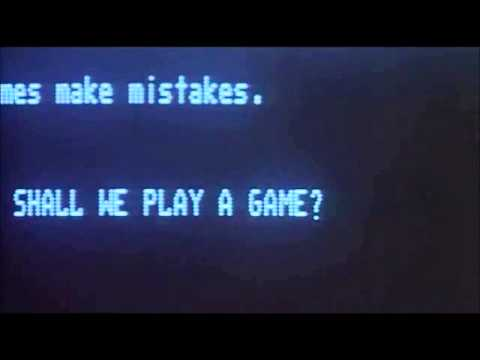

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('B53Vlje7mcM')

Now we can use this to play an exciting game.  Watchout Rockstar Games, you may have GTA...but I've got "GTN"!

(GTN=Guess That Number).

Run this code below to pick a random number between 0 and 9, add noise to it and display the result.

In [25]:
difficulty = 15;
correct_answer = random.randrange(0,10);
print (bits2image( addnoise( image2bits( image[correct_answer] ), difficulty/100.0) ));

XX X 
     
X XXX
    X
 X X 


In [26]:
selected_idx = []
for i in range(0, 20):
    difficulty = 0;
    correct_answer = random.randrange(0,10);
    selected_idx.append(correct_answer)
    print (bits2image( addnoise( image2bits( image[correct_answer] ), difficulty/100.0) ));
    print (" ")

 XXX 
X    
XXXX 
X   X
 XXX 
 
 XXX 
X   X
 XXXX
    X
 XXX 
 
 XXX 
    X
 XXX 
    X
 XXX 
 
 XXX 
    X
 XXX 
    X
 XXX 
 
   X 
  XX 
 X X 
XXXXX
   X 
 
 XXX 
X   X
 XXXX
    X
 XXX 
 
 XXX 
    X
   X 
  X  
XXXXX
 
 XXX 
X   X
 XXXX
    X
 XXX 
 
XXXXX
X    
XXXX 
    X
XXXX 
 
XXXXX
X    
XXXX 
    X
XXXX 
 
XXXXX
X    
XXXX 
    X
XXXX 
 
 XXX 
    X
 XXX 
    X
 XXX 
 
 XXX 
X    
XXXX 
X   X
 XXX 
 
 XXX 
X   X
 XXXX
    X
 XXX 
 
  X  
 XX  
  X  
  X  
 XXX 
 
 XXX 
    X
 XXX 
    X
 XXX 
 
   X 
  XX 
 X X 
XXXXX
   X 
 
 XXX 
X   X
 XXX 
X   X
 XXX 
 
 XXX 
X    
XXXX 
X   X
 XXX 
 
 XXX 
    X
   X 
  X  
XXXXX
 


In [27]:
print(selected_idx)  

[6, 9, 3, 3, 4, 9, 2, 9, 5, 5, 5, 3, 6, 9, 1, 3, 4, 8, 6, 2]


## Take a guess:
Enter your guess as to what the character above represents on the line below.

In [28]:
your_guess = 5;

Did you guess correctly?  Run the code below to discover the outcome...

In [29]:
if your_guess == correct_answer:
    print ("OK");
else:
    print ("Global Thermonuclear War Initiated");
    print ("The correct answer was: %d" % correct_answer);

Global Thermonuclear War Initiated
The correct answer was: 2


You can replay this game a few times by rerunning the last 3 code cells.

For best results, I recommending loading a browser window on your XBox360 or PS4 to play GTN at optimum frame-rates.

## Machine Learning Time:  Enter the Tensor!

Activate Tensor Power!

In [30]:
import tensorflow as tf
import numpy as np

We will create a network with one hidden layer (plus and input layer and an output layer).

There will be a weight matrix connecting the input layer to the hidden layer, and a weight matrix connection the hidden layer to the output layer.  In addition, each hidden and output node will have a bias or offset value.

We will initialize all of the trainable parameters to random values chosen from a uniform distribution with low and high values specified by a heuristic from a 2010 paper by Glorot and Bengio.

We will then define some calculations:  h_in, h_out, o_in, y_pred to calculate how the activation values are computed through successive layers.  Then we define cost, accuracy, and train_op, which are procedures to compute the cost (error) or the network, its accuracy, and its weight updates.

Finally, the function returns input_x so that users have access to the network's input layer, label_y so that user's can specify the desired output, accuracy to computer accruacy, cost to compute cost, train_op to train one epoch of data, and y_pred to look at the network output.

Note that the entire function below, doesn't calculate anything, not evern when you run it!  It merely defines <i><b>how</b></i> to calculate it.  Think of it as compiling the code to do the math.  The math isn't yet being performed, the code is just being defined and compiled.

In [31]:
from numpy.random import uniform
DTYPE = 'float32'
EPS = np.finfo(np.double).eps

def construct_model(n_inputs, n_hidden, n_outputs, lr):
    """Declare Parameters
    """
    # initialization from Glorot and Bengio 2010.
    W_hid = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_inputs + n_hidden)), \
                                  high=4 * np.sqrt(6.0 / (n_inputs + n_hidden)),\
                                  size=(n_inputs,n_hidden) \
                                ).astype('float32'), \
                         name='W_h' )
    
    b_hid = tf.Variable( np.zeros( [n_hidden], dtype=DTYPE ), \
                         name='b_h' )

    W_out = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  high=4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  size=(n_hidden, n_outputs) \
                                ).astype('float32'), \
                         name='W_o' )
    
    b_out =  tf.Variable( tf.zeros([n_outputs]), 
                          name='b_o' )
    
    input_x = tf.placeholder( "float", [None, n_inputs] ) # create symbolic variables
    
    #The label.
    label_y = tf.placeholder( "float", [None, n_outputs] )
    
    h_in = tf.nn.bias_add(tf.matmul(input_x,W_hid),b_hid) # define net input calculation to hidden units
    h_out = tf.sigmoid(h_in)  # define squashing function (non-linearity) to hidden units
    
    o_in = tf.nn.bias_add(tf.matmul(h_out, W_out), b_out) # define net input calculation to output units
    y_pred = tf.sigmoid(o_in) # define squashing function (non-linearity) to output units
    
    cost = -tf.reduce_mean( label_y * tf.log(y_pred + EPS) + \
                            (1 - label_y) * tf.log(1 - y_pred + EPS) )
        # add EPS to prevent taking logarithm of zeron when y_pred = 0 or 1
        # if label_y and y_pred are both 0, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred are both 1, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred differ are 0 and 1 (respectively), then top half of the equation is zero and bottom -16
        # if label_y and y_pred differ are 1 and 0 (respectively), then top half of the equation is -16 and bottom zero

    train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # generate code to compute accuracy
    # if element > 0.5 replace with 1.
    bool_vec = tf.greater(y_pred, 0.5)
    correct_prediction = tf.equal(label_y, tf.cast(bool_vec, tf.float32))
    # convert all boolean to float, to calculate percentage
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return input_x, label_y, accuracy, cost, train_op, y_pred;


We can use the function as follows to access the inputs, target outputs and functions within the model.

In [32]:
input_x, label_y, accuracy, cost, train_op, y_pred = construct_model( 25, 30, 10, 0.1 )

At this point we have only created and defined our network.  We haven't run anything.

Next, lets generate our training data.

In [33]:
input_data, target_data = perfect_data();  # get some data to use

Below, we create a train_network function which repatedly runs train_op to train the network for a specified number of epochs.


In [34]:
import matplotlib.pyplot as plt

def train_network(epochs):
    sess = tf.Session()   # execute the tensor flow session
    
    
    
    sess.run(tf.global_variables_initializer())   # initialize all the global variables

    train_costs = np.zeros(epochs, dtype='float32');
    train_accuracies = np.zeros(epochs, dtype='float32');
    
    ### TRAINING BEGIN ###
    print ("Epoch  Cost   Accuracy")
    for i in range(epochs):
        train_cost, train_accuracy, _ = sess.run([cost, accuracy, train_op], feed_dict={input_x: input_data, label_y: target_data})
        train_costs[i] = train_cost
        train_accuracies[i] = train_accuracy
        if i % 200 == 0:
            print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));
    print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));        
    ### TRAINING END ###
    
    return train_costs, train_accuracies, y_pred, sess;

Then we run it for 5000 epochs (finally!).

In [35]:
train_costs, train_accuracies, y_pred, sess = train_network(5000)


Epoch  Cost   Accuracy
00000  1.790  0.360
00200  0.321  0.890
00400  0.239  0.900
00600  0.195  0.910
00800  0.166  0.920
01000  0.145  0.960
01200  0.129  0.960
01400  0.116  0.960
01600  0.105  0.960
01800  0.097  0.970
02000  0.089  0.980
02200  0.082  0.990
02400  0.076  0.990
02600  0.071  0.990
02800  0.066  0.990
03000  0.062  0.990
03200  0.058  0.990
03400  0.055  0.990
03600  0.052  1.000
03800  0.049  1.000
04000  0.046  1.000
04200  0.044  1.000
04400  0.042  1.000
04600  0.040  1.000
04800  0.038  1.000
04999  0.036  1.000


Let's plot it!

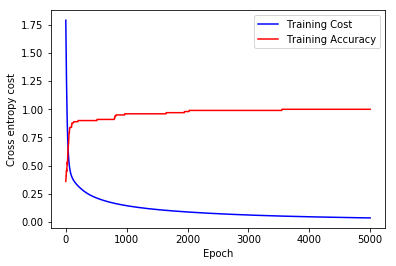

In [36]:
plt.plot(train_costs, '-b', label="Training Cost")
plt.plot(train_accuracies, '-r', label="Training Accuracy")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy cost")
plt.show()
 

Error went down, but what is it really outputting for each input pattern?

In [37]:
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
for digit in range(0,10):
    print (image[digit]);
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print;
    print (80*"-");

 XXX 
X   X
X   X
X   X
 XXX 

['0.9', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 0
--------------------------------------------------------------------------------
  X  
 XX  
  X  
  X  
 XXX 

['0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 1
--------------------------------------------------------------------------------
 XXX 
    X
   X 
  X  
XXXXX

['0.0', '0.0', '0.9', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 2
--------------------------------------------------------------------------------
 XXX 
    X
 XXX 
    X
 XXX 

['0.0', '0.0', '0.0', '0.6', '0.0', '0.0', '0.0', '0.0', '0.1', '0.1']
Prediction: 3
--------------------------------------------------------------------------------
   X 
  XX 
 X X 
XXXXX
   X 

['0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 4
--------------------------------------------------------------------------------
XXXXX
X    
XXX

In [38]:
selected_idx = [2, 3, 7, 2, 7, 9, 9, 5, 4, 0, 5, 2, 9, 1, 8, 4, 9, 9, 2, 7]

In [39]:
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
#print(test_target_data[1])
predicted_correct = 1
for digit in selected_idx:
    print (image[digit]);
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print;
    print (80*"-");
    if o.index(max(o)) == np.where(target_data[digit]==1)[0]:
        predicted_correct += 1

accuracy = predicted_correct/(len(selected_idx)+1)*100
print("Accuracy: %.4f" % accuracy)

 XXX 
    X
   X 
  X  
XXXXX

['0.0', '0.0', '0.9', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 2
--------------------------------------------------------------------------------
 XXX 
    X
 XXX 
    X
 XXX 

['0.0', '0.0', '0.0', '0.6', '0.0', '0.0', '0.0', '0.0', '0.1', '0.1']
Prediction: 3
--------------------------------------------------------------------------------
XXXXX
   X 
  X  
 X   
X    

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0']
Prediction: 7
--------------------------------------------------------------------------------
 XXX 
    X
   X 
  X  
XXXXX

['0.0', '0.0', '0.9', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 2
--------------------------------------------------------------------------------
XXXXX
   X 
  X  
 X   
X    

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0']
Prediction: 7
--------------------------------------------------------------------------------
 XXX 
X   X
 XX

Nice! The highest output is always for the corret input pattern.

But, how will it do on noisy data?

In [84]:
input_data = np.array( [ addnoise( image2bits( image[digit] ), 0.10 ) for digit in range(0,10) ] );
output_data = np.array( [ onehot(digit,10) for digit in range(0,10)] );
print(output_data)
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
for digit in range(0,10):
    print (bits2image( input_data[digit] ));
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print;
    print (80*"-");

TypeError: 'int' object is not iterable

In [41]:
selected_idx = [7, 2, 4, 7, 6, 0, 7, 6, 9, 5, 4, 1, 1, 1, 3, 8, 5, 5, 9, 3]

In [83]:
input_data = np.array( [ addnoise( image2bits( image[digit] ), 0.10 ) for digit in range(0,10) ] );
print(input_data)
output_data = np.array( [ onehot(digit,10) for digit in range(0,10)] );
print(output_data)
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
for digit in range(0,10):
    print (bits2image( input_data[digit] ));
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print;
    print (80*"-");

TypeError: 'int' object is not iterable

In [51]:
noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
selected_idx = [[2, 3, 7, 2, 7, 9, 9, 5, 4, 0, 5, 2, 9, 1, 8, 4, 9, 9, 2, 7],
                [7, 2, 4, 7, 6, 0, 7, 6, 9, 5, 4, 1, 1, 1, 3, 8, 5, 5, 9, 3],
                [5, 7, 9, 4, 6, 1, 7, 6, 5, 6, 9, 1, 7, 3, 8, 1, 4, 7, 4, 7],
                [2, 6, 7, 2, 2, 6, 5, 6, 5, 1, 0, 0, 9, 3, 6, 6, 6, 2, 9, 6],
                [5, 5, 5, 0, 4, 9, 9, 7, 0, 8, 4, 1, 2, 9, 1, 9, 9, 6, 5, 8],
                [2, 3, 6, 8, 4, 7, 6, 3, 4, 2, 4, 1, 3, 0, 1, 0, 0, 6, 5, 5],
                [4, 9, 6, 3, 0, 6, 8, 7, 8, 1, 9, 8, 1, 8, 0, 7, 6, 6, 1, 5]]

correct_labels = []
correct_labels_list = []
for noise in noise_levels:
    for i in range(0, 20):
        difficulty = noise;
        correct_answer = random.randrange(0,10);
        correct_labels.append(correct_answer)
        #print (bits2image( addnoise( image2bits( image[correct_answer] ), difficulty/100.0) ));
        #print (" ")
    correct_labels_list.append(correct_labels)
    
# TODO do we feed the input_data and target_data with the indices from above into feed_dict?
    
test_accuracy_list = []
for i, noise in enumerate(noise_levels):
    #input_data = np.array( [ addnoise( image2bits( image[digit] ), noise ) for digit in range(0,10) ] );
    print(image[i])
    input_data = np.array( [ addnoise( image2bits( image[digit] ), noise ) for digit in selected_idx[i] ] );
    #print(input_data)
    
    target_data = target_data[selected_idx[i]]
    #output_data = np.array( [ onehot(digit,10) for digit in range(0,10)] );

    outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
    predicted_correct = 0
    for digit in selected_idx[i]:
        o = outputs[digit].tolist();
        
        if o.index(max(o)) == np.where(target_data[digit]==1)[0]:
            predicted_correct += 1
            #print ("Correct")
    #print(selected_idx[i])
    test_accuracy = (predicted_correct/(len(selected_idx[i])))*100
    #print("Noise Level: {} Accuracy: {}".format(noise, accuracy))
    test_accuracy_list.append(test_accuracy)

 XXX 
X   X
X   X
X   X
 XXX 

  X  
 XX  
  X  
  X  
 XXX 

 XXX 
    X
   X 
  X  
XXXXX

 XXX 
    X
 XXX 
    X
 XXX 

   X 
  XX 
 X X 
XXXXX
   X 

XXXXX
X    
XXXX 
    X
XXXX 

 XXX 
X    
XXXX 
X   X
 XXX 



In [58]:
import random

noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
correct_labels_list = []
test_input_data = []
for i, noise in enumerate(noise_levels):
    correct_labels=[random.randrange(0,10) for _ in range (20)]
    correct_labels_list.append(correct_labels)
    test_data = [ addnoise( image2bits( image[digit] ), noise ) for digit in correct_labels] ;
    test_input_data.append(test_data)
np.vstack(test_input_data)

array([[1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 1, 1],
       ..., 
       [0, 1, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [59]:
correct_labels_list

[[5, 4, 2, 7, 8, 0, 2, 8, 5, 3, 8, 9, 7, 9, 1, 0, 6, 7, 4, 1],
 [8, 7, 9, 5, 6, 9, 6, 9, 3, 2, 3, 7, 6, 6, 6, 7, 0, 0, 8, 8],
 [4, 1, 6, 9, 0, 1, 2, 2, 4, 2, 3, 4, 2, 3, 8, 6, 1, 6, 1, 1],
 [6, 3, 5, 9, 8, 4, 4, 2, 7, 6, 4, 2, 6, 4, 9, 6, 5, 2, 0, 5],
 [0, 8, 6, 8, 9, 4, 2, 4, 5, 7, 7, 6, 4, 3, 2, 1, 2, 2, 1, 7],
 [0, 5, 3, 3, 3, 5, 1, 5, 4, 8, 5, 2, 5, 9, 7, 8, 5, 7, 1, 4],
 [4, 5, 1, 7, 1, 3, 1, 9, 8, 6, 4, 9, 3, 1, 8, 5, 6, 2, 1, 4]]

In [60]:
test_input_data

[[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
  [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1

In [61]:
len(test_input_data)

7

In [75]:
count = 0
one_hot_output_data = []
for i, test in enumerate(test_input_data):
    #print(test)
    output_data = np.array( [ onehot(digit,10) for digit in correct_labels_list[i]] );
    one_hot_output_data = np.append(one_hot_output_data, output_data)
    for j, img in enumerate(test):
        #print(img)
        #print(bits2image(img))
        count += 1

In [77]:
print(len(one_hot_output_data))

1400
